<a href="https://colab.research.google.com/github/minjilee-purdue/erc_tree_semantic_segmentation_in_mlops/blob/main/cv_prerequisite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prerequisites for training CNN and Vision Transformer models: raw aerial imagery, segmentation masks, and object contours.

This cv_prerequisite.ipynb elaborates on several techniques based on original images.

* Original Image: It is an aerial and drone view of a landscape. It appears to be a field or grassy area with some trees/bushes scattered around. The ground cover has a mix of brown and tan colors, suggesting dormant vegetation or dry grass. Majority of the dataset includes salient or concealed (indistict) Eastern Red Cedar (ERC) trees within the image.

* Original Mask Image: This image shows a mask applied to the original image, likely for object detection or segmentation purposes. The different colors represent different segmented regions, corresponding to the individual ERC trees or bushes in the original image.

* Original Color Contours: This displays the outlines or contours of the objects, with each object having a different colored contour.

* White Contours: This image shows the contours of the objects, but this time, all contours are white. This could be a simplified representation for further processing.

First of all, we need to import libraries and install packages.

In [ ]:
# Install required packages (if not already installed)
!pip install matplotlib numpy opencv-python scipy

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from google.colab import files
from scipy.spatial import KDTree
import os

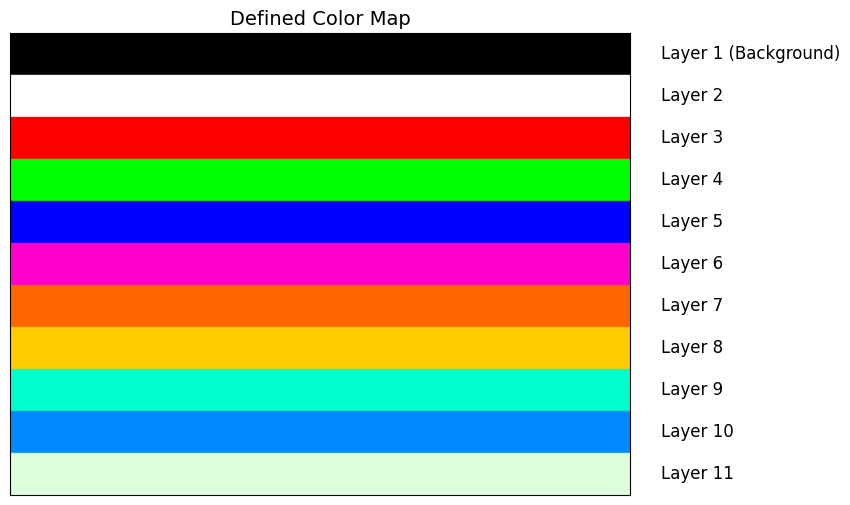

In [ ]:
# Define the color map in hexadecimal. We will use this color map for segmentation bounding box
# The first layer is not considered a segmentation level, as it serves as the default background
color_map = {
    "Layer 1 (Background)": "#000000",
    "Layer 2": "#ffffff",
    "Layer 3": "#ff0000",
    "Layer 4": "#00ff00",
    "Layer 5": "#0000ff",
    "Layer 6": "#ff00cc",
    "Layer 7": "#ff6600",
    "Layer 8": "#ffcc00",
    "Layer 9": "#00ffcc",
    "Layer 10": "#0088ff",
    "Layer 11": "#ddffdc",
}

# Plot the colors
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, len(color_map))

for i, (layer, hex_color) in enumerate(color_map.items()):
    ax.add_patch(plt.Rectangle((0, i), 1, 1, color=hex_color))
    ax.text(1.05, i + 0.5, layer, va='center', fontsize=12, color="black")

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Defined Color Map", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

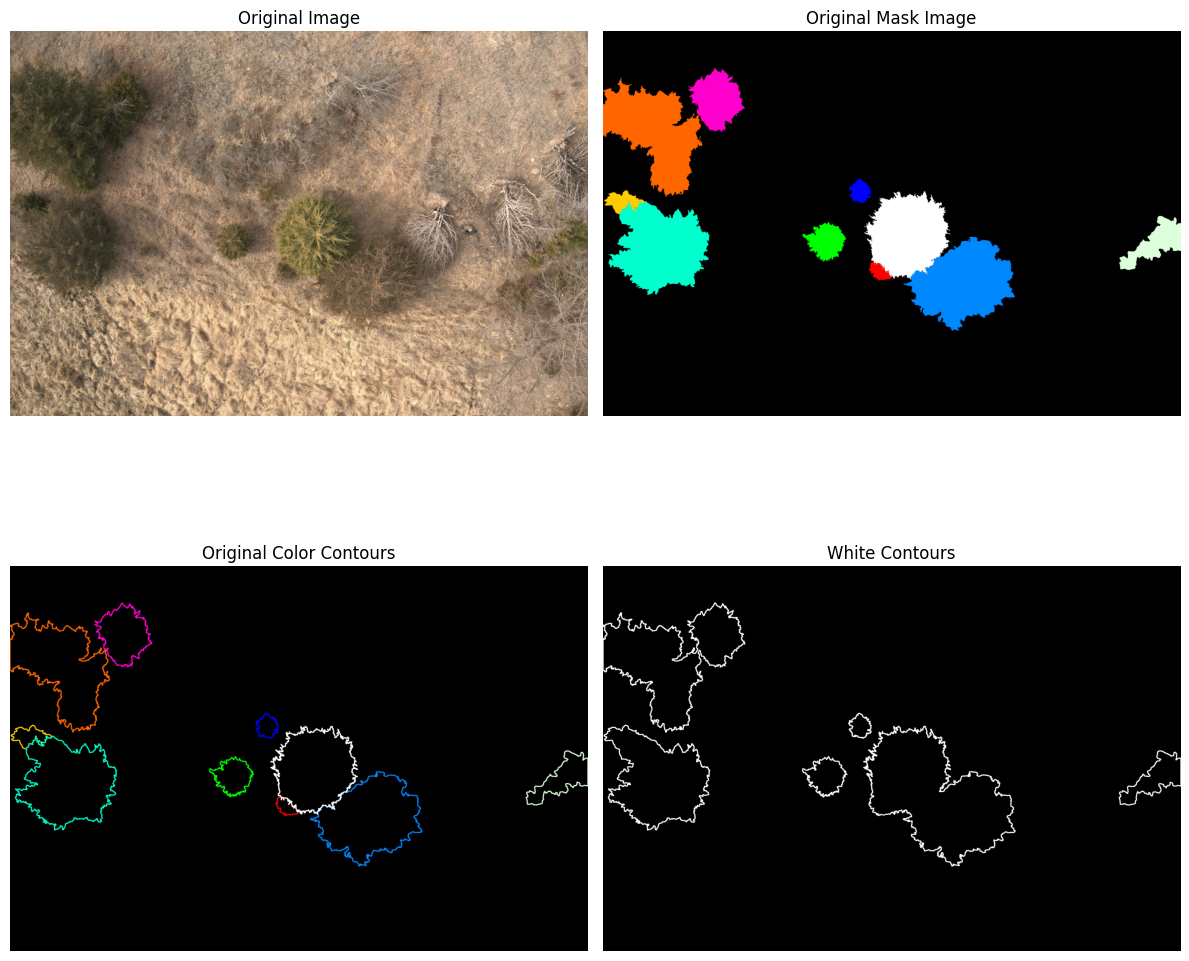

In [ ]:
# Re-load necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define file paths for original image and mask
original_path = "/content/MAX_0086_enhanced_final.jpg"  # Update with correct filename if needed
mask_path = "/content/MAX_0086_enhanced_final.png"  # Update with correct filename if needed

# Load images
original = cv2.imread(original_path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convert for correct display in matplotlib
mask = cv2.imread(mask_path)  # Load mask in BGR format

# Convert mask to grayscale for contour detection
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Find contours in the grayscale mask
contours, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create black background images for contours
white_contour_img = np.zeros_like(mask)  # For white contours
color_contour_img = np.zeros_like(mask)  # For color contours

# Draw white contours
cv2.drawContours(white_contour_img, contours, -1, (255, 255, 255), thickness=10)

# Extract unique colors from the mask (excluding black)
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
unique_colors = [tuple(map(int, color)) for color in unique_colors if not np.all(color == [0, 0, 0])]

# Draw original color contours
for color in unique_colors:
    # Create binary mask for the specific color
    color_mask = cv2.inRange(mask, np.array(color), np.array(color))

    # Find contours for the current color
    color_contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours using the corresponding color
    cv2.drawContours(color_contour_img, color_contours, -1, color, thickness=10)

# Display the results in a 2x2 grid layout
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Original Image")
ax[0, 0].imshow(original_rgb)
ax[0, 0].axis("off")

ax[0, 1].set_title("Original Mask Image")
ax[0, 1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
ax[0, 1].axis("off")

ax[1, 0].set_title("Original Color Contours")
ax[1, 0].imshow(cv2.cvtColor(color_contour_img, cv2.COLOR_BGR2RGB))
ax[1, 0].axis("off")

ax[1, 1].set_title("White Contours")
ax[1, 1].imshow(cv2.cvtColor(white_contour_img, cv2.COLOR_BGR2RGB))
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Load images
original = cv2.imread(original_path)
mask = cv2.imread(mask_path)

if mask is None:
  print("Error, couldn't load mask image")

else:
# Define the color map (excluding background)
    color_map = {
        "Layer 2": "#ffffff",
        "Layer 3": "#ff0000",
        "Layer 4": "#00ff00",
        "Layer 5": "#0000ff",
        "Layer 6": "#ff00cc",
        "Layer 7": "#ff6600",
        "Layer 8": "#ffcc00",
        "Layer 9": "#00ffcc",
        "Layer 10": "#0088ff",
        "Layer 11": "#ddffdc",
    }

# Convert hex colors to BGR tuples
color_map_bgr = {
    layer: tuple(int(hex_color[i:i+2], 16) for i in (5, 3, 1))  # BGR conversion
    for layer, hex_color in color_map.items()
}

# Create a dictionary to store bounding box coordinates for each layer
layer_bboxes = {}

# Draw original color contours
for color in unique_colors:
    # Create binary mask for the specific color
    color_mask = cv2.inRange(mask, np.array(color), np.array(color))

    # Find contours for the current color
    color_contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Store bounding box coordinates for the current layer
    layer_bboxes[layer] = []
    for contour in color_contours:
        x, y, w, h = cv2.boundingRect(contour)
        xmin = x
        ymin = y
        xmax = x + w
        ymax = y + h
        layer_bboxes[layer].append((xmin, ymin, xmax, ymax))

# Print the bounding box coordinates for each layer in the desired format
for layer, bboxes in layer_bboxes.items():
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        print(f"{layer}: {xmin}, {ymin}, {xmax}, {ymax}")


Layer 2: 3288, 1996, 3289, 1997
Layer 2: 2490, 1830, 2492, 1834
Layer 2: 3008, 1545, 3009, 1546
Layer 2: 2469, 1519, 3290, 2352


🔼 Please upload your mask image:


Saving MAX_0086_enhanced_final.png to MAX_0086_enhanced_final (2).png

🔼 Please upload your original image:


Saving MAX_0086_enhanced_final.jpg to MAX_0086_enhanced_final (2).jpg
Summary of detected regions:
Layer 2: 1 regions detected
Layer 3: 1 regions detected
Layer 4: 1 regions detected
Layer 5: 1 regions detected
Layer 6: 1 regions detected
Layer 7: 1 regions detected
Layer 8: 1 regions detected
Layer 9: 1 regions detected
Layer 10: 1 regions detected
Layer 11: 1 regions detected


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

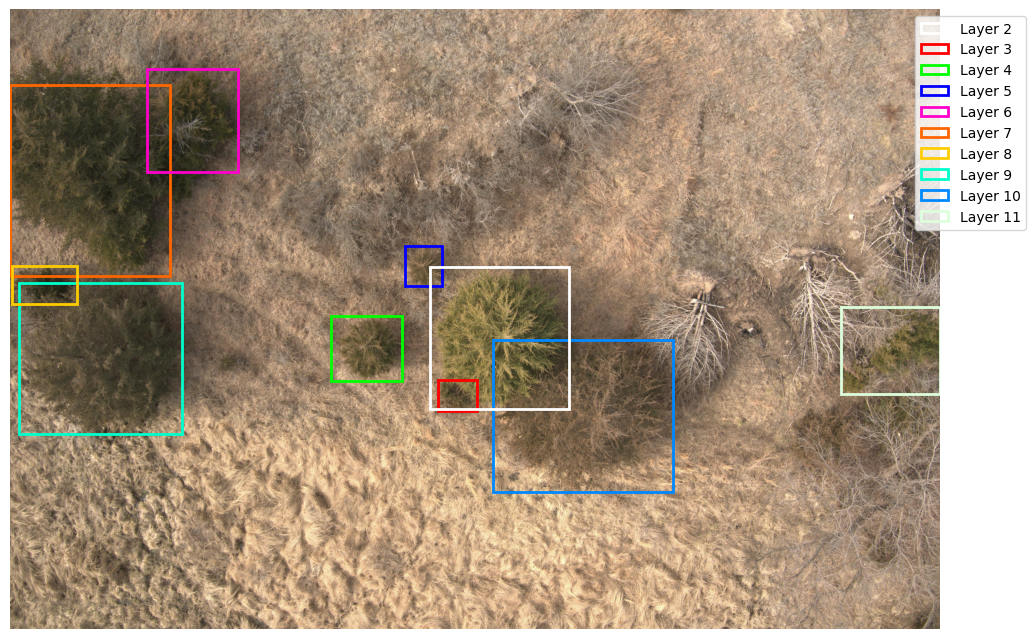

In [ ]:
# or you can upload google colab directly
print("🔼 Please upload your mask image:")
uploaded_mask = files.upload()
mask_filename = list(uploaded_mask.keys())[0]

print("\n🔼 Please upload your original image:")
uploaded_original = files.upload()
original_filename = list(uploaded_original.keys())[0]

# Load images
mask_image = cv2.imread(mask_filename)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

'''
# Define the correct color map based on your specification
color_map = {
    "Layer 1 (Background)": "#000000",
    "Layer 2": "#ffffff",
    "Layer 3": "#ff0000",
    "Layer 4": "#00ff00",
    "Layer 5": "#0000ff",
    "Layer 6": "#ff00cc",
    "Layer 7": "#ff6600",
    "Layer 8": "#ffcc00",
    "Layer 9": "#00ffcc",
    "Layer 10": "#0088ff",
    "Layer 11": "#ddffdc",
}
'''

# Define colors to exclude from processing (background and potentially noisy colors)
excluded_colors = ["#000000"]  # Exclude black background

# Convert color map to RGB for comparison
color_map_rgb = {}
for name, hex_code in color_map.items():
    if hex_code not in excluded_colors:  # Skip excluded colors
        color_map_rgb[hex_code] = tuple(int(hex_code[i:i+2], 16) for i in (1, 3, 5))

# Extract unique colors from the mask image
unique_colors = np.unique(mask_image.reshape(-1, 3), axis=0)
extracted_colors = {f"#{r:02x}{g:02x}{b:02x}": (r, g, b) for r, g, b in unique_colors}

# Function to find the closest matching color from the predefined color map
def find_closest_color(target_rgb, reference_colors):
    reference_rgb_values = np.array(list(reference_colors.values()))
    kd_tree = KDTree(reference_rgb_values)
    _, index = kd_tree.query(target_rgb)
    return list(reference_colors.values())[index]

# Map extracted colors to the closest predefined colors
corrected_colors = {}
for hex_color, rgb in extracted_colors.items():
    if hex_color not in excluded_colors:  # Skip excluded colors
        corrected_colors[hex_color] = find_closest_color(rgb, color_map_rgb)

# Convert corrected colors back to hex format
corrected_colors_hex = {orig: f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}" for orig, rgb in corrected_colors.items()}

# Function to extract bounding boxes from a color mask using corrected colors
def extract_bounding_boxes(mask_image, corrected_colors, min_area=100):
    color_bboxes = {}
    color_index_map = {tuple(int(corrected_hex[i:i+2], 16) for i in (1, 3, 5)): corrected_hex
                       for corrected_hex in corrected_colors.values()}

    for target_rgb, corrected_hex in color_index_map.items():
        binary_mask = np.all(mask_image == target_rgb, axis=2).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if corrected_hex not in color_bboxes:
            color_bboxes[corrected_hex] = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area >= min_area:  # Only include contours above the minimum area threshold
                x, y, w, h = cv2.boundingRect(contour)
                color_bboxes[corrected_hex].append((x, y, w, h))

    return color_bboxes

# Extract bounding boxes using the optimized method with minimum area threshold
min_area_threshold = 500  # Adjust this value based on your needs
color_bboxes = extract_bounding_boxes(mask_image, corrected_colors_hex, min_area=min_area_threshold)

# Function to draw bounding boxes on the original image and save output
def draw_bounding_boxes(original_image_path, color_bboxes, output_path="output_filtered.png"):
    original = cv2.imread(original_image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 10))
    plt.imshow(original)

    # Create a legend to show box colors and their layer names
    legend_patches = []

    # Define color_to_layer mapping
    color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

    # Create ordered legend based on layer numbers
    ordered_colors = []
    for name in sorted(color_map.keys(), key=lambda x: int(x.split()[1].split('(')[0])):
        hex_code = color_map[name]
        if hex_code in color_bboxes:
            ordered_colors.append(hex_code)
            legend_patches.append(Rectangle((0, 0), 1, 1, linewidth=2, edgecolor=hex_code,
                                           facecolor='none', label=name))

    # Draw bounding boxes
    for color_hex, bboxes in color_bboxes.items():
        for (x, y, w, h) in bboxes:
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color_hex, facecolor='none')
            plt.gca().add_patch(rect)

    # Add legend to the plot with ordered layers
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.axis('off')

    # Save the output image
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0, dpi=300)

    # Download the image in Colab
    files.download(output_path)

    plt.show()

# Print summary of detected regions in order from Layer 2 to Layer 10
print("Summary of detected regions:")

# Define color_to_layer mapping
color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

# Sort layers by their number and create a mapping from layer name to detected boxes
layer_to_boxes = {}
for color_hex, bboxes in color_bboxes.items():
    layer_name = color_to_layer.get(color_hex, f"Unknown ({color_hex})")
    layer_to_boxes[layer_name] = len(bboxes)

# Print in specific order (Layer 2 to Layer 11)
ordered_layers = sorted(
    [name for name in color_to_layer.values() if name != "Layer 1 (Background)"],
    key=lambda x: int(x.split()[1].split('(')[0])
)

for layer_name in ordered_layers:
    if layer_name in layer_to_boxes:
        print(f"{layer_name}: {layer_to_boxes[layer_name]} regions detected")

# Draw bounding boxes and save output
draw_bounding_boxes(original_filename, color_bboxes)

Summary of detected regions:
Layer 2: 1 regions detected
Layer 3: 1 regions detected
Layer 4: 1 regions detected
Layer 5: 1 regions detected
Layer 6: 1 regions detected
Layer 7: 1 regions detected
Layer 8: 1 regions detected
Layer 9: 1 regions detected
Layer 10: 1 regions detected
Layer 11: 1 regions detected


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

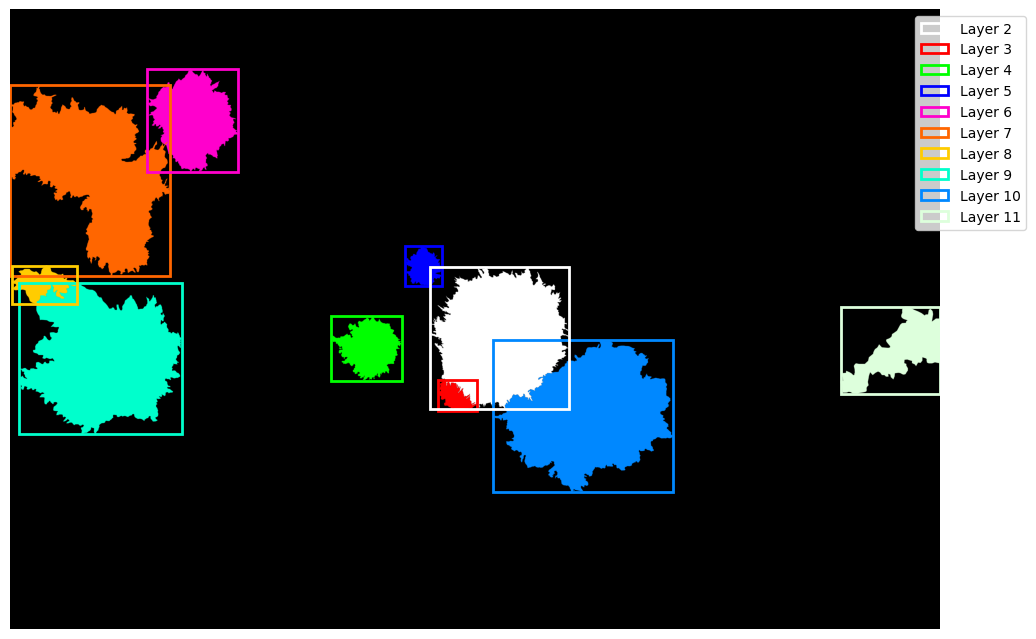

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define the correct color map (same above)
'''
color_map = {
    "Layer 1 (Background)": "#000000",
    "Layer 2": "#ffffff",
    "Layer 3": "#ff0000",
    "Layer 4": "#00ff00",
    "Layer 5": "#0000ff",
    "Layer 6": "#ff00cc",
    "Layer 7": "#ff6600",
    "Layer 8": "#ffcc00",
    "Layer 9": "#00ffcc",
    "Layer 10": "#0088ff",
    "Layer 11": "#ddffdc",
}
'''
# Define colors to exclude from processing (background and potentially noisy colors)
excluded_colors = ["#000000"]  # Exclude black background

# Convert color map to RGB for comparison
color_map_rgb = {}
for name, hex_code in color_map.items():
    if hex_code not in excluded_colors:  # Skip excluded colors
        color_map_rgb[hex_code] = tuple(int(hex_code[i:i+2], 16) for i in (1, 3, 5))

# Extract unique colors from the mask image
unique_colors = np.unique(mask_image.reshape(-1, 3), axis=0)
extracted_colors = {f"#{r:02x}{g:02x}{b:02x}": (r, g, b) for r, g, b in unique_colors}

# Function to find the closest matching color from the predefined color map
def find_closest_color(target_rgb, reference_colors):
    reference_rgb_values = np.array(list(reference_colors.values()))
    kd_tree = KDTree(reference_rgb_values)
    _, index = kd_tree.query(target_rgb)
    return list(reference_colors.values())[index]

# Map extracted colors to the closest predefined colors
corrected_colors = {}
for hex_color, rgb in extracted_colors.items():
    if hex_color not in excluded_colors:  # Skip excluded colors
        corrected_colors[hex_color] = find_closest_color(rgb, color_map_rgb)

# Convert corrected colors back to hex format
corrected_colors_hex = {orig: f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}" for orig, rgb in corrected_colors.items()}

# Function to extract bounding boxes from a color mask using corrected colors
def extract_bounding_boxes(mask_image, corrected_colors, min_area=100):
    color_bboxes = {}
    color_index_map = {tuple(int(corrected_hex[i:i+2], 16) for i in (1, 3, 5)): corrected_hex
                       for corrected_hex in corrected_colors.values()}

    for target_rgb, corrected_hex in color_index_map.items():
        binary_mask = np.all(mask_image == target_rgb, axis=2).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if corrected_hex not in color_bboxes:
            color_bboxes[corrected_hex] = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area >= min_area:  # Only include contours above the minimum area threshold
                x, y, w, h = cv2.boundingRect(contour)
                color_bboxes[corrected_hex].append((x, y, w, h))

    return color_bboxes

# Extract bounding boxes using the optimized method with minimum area threshold
min_area_threshold = 500  # Adjust this value based on your needs
color_bboxes = extract_bounding_boxes(mask_image, corrected_colors_hex, min_area=min_area_threshold)

# Function to draw bounding boxes directly on the mask image and save output
def draw_bounding_boxes_on_mask(mask_image, color_bboxes, output_path="mask_with_bboxes.png"):
    # Create a copy of the mask image to draw on
    mask_with_boxes = mask_image.copy()

    # Define color_to_layer mapping
    color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

    # Create figure
    plt.figure(figsize=(12, 10))
    plt.imshow(mask_with_boxes)

    # Create ordered legend based on layer numbers
    legend_patches = []
    ordered_colors = []
    for name in sorted(color_map.keys(), key=lambda x: int(x.split()[1].split('(')[0])):
        hex_code = color_map[name]
        if hex_code in color_bboxes:
            ordered_colors.append(hex_code)
            legend_patches.append(Rectangle((0, 0), 1, 1, linewidth=2, edgecolor=hex_code,
                                           facecolor='none', label=name))

    # Draw bounding boxes directly on the image
    for color_hex, bboxes in color_bboxes.items():
        # Convert hex to RGB for OpenCV drawing
        r = int(color_hex[1:3], 16)
        g = int(color_hex[3:5], 16)
        b = int(color_hex[5:7], 16)
        box_color = (r, g, b)

        for (x, y, w, h) in bboxes:
            # Draw rectangle on the mask image copy
            cv2.rectangle(mask_with_boxes, (x, y), (x + w, y + h), box_color, 2)

            # Also add rectangle to matplotlib for the legend
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color_hex, facecolor='none')
            plt.gca().add_patch(rect)

    # Add legend to the plot with ordered layers
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.axis('off')

    # Save the output image
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0, dpi=300)

    # Download the image in Colab
    files.download(output_path)

    plt.show()

    return mask_with_boxes

# Print summary of detected regions in order from Layer 2 to Layer 11
print("Summary of detected regions:")

# Define color_to_layer mapping
color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

# Sort layers by their number and create a mapping from layer name to detected boxes
layer_to_boxes = {}
for color_hex, bboxes in color_bboxes.items():
    layer_name = color_to_layer.get(color_hex, f"Unknown ({color_hex})")
    layer_to_boxes[layer_name] = len(bboxes)

# Print in specific order
ordered_layers = sorted(
    [name for name in color_to_layer.values() if name != "Layer 1 (Background)"],
    key=lambda x: int(x.split()[1].split('(')[0])
)

for layer_name in ordered_layers:
    if layer_name in layer_to_boxes:
        print(f"{layer_name}: {layer_to_boxes[layer_name]} regions detected")

# Draw bounding boxes directly on mask and save output
result_image = draw_bounding_boxes_on_mask(mask_image, color_bboxes)

# If you want to also save the result as an OpenCV image without matplotlib
cv2.imwrite("mask_with_boxes_cv2.png", cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
files.download("mask_with_boxes_cv2.png")

🔼 Please upload your mask image:


Saving MAX_0020_enhanced_final.png to MAX_0020_enhanced_final (3).png

🔼 Please upload your original image:


Saving MAX_0020_enhanced_final.jpg to MAX_0020_enhanced_final (3).jpg

===== BOUNDING BOX COORDINATES =====
Layer 2 (#ffffff): xmin: 2610, ymin: 2430, xmax: 2917, ymax: 2765
Layer 3 (#ff0000): xmin: 3235, ymin: 428, xmax: 3438, ymax: 716
Layer 4 (#00ff00): xmin: 4308, ymin: 861, xmax: 4476, ymax: 999
Layer 5 (#0000ff): xmin: 4048, ymin: 1273, xmax: 4360, ymax: 1561
Layer 6 (#ff00cc): xmin: 4622, ymin: 600, xmax: 4745, ymax: 753

Summary of detected regions:
Layer 2: 1 regions detected
Layer 3: 1 regions detected
Layer 4: 1 regions detected
Layer 5: 1 regions detected
Layer 6: 1 regions detected


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

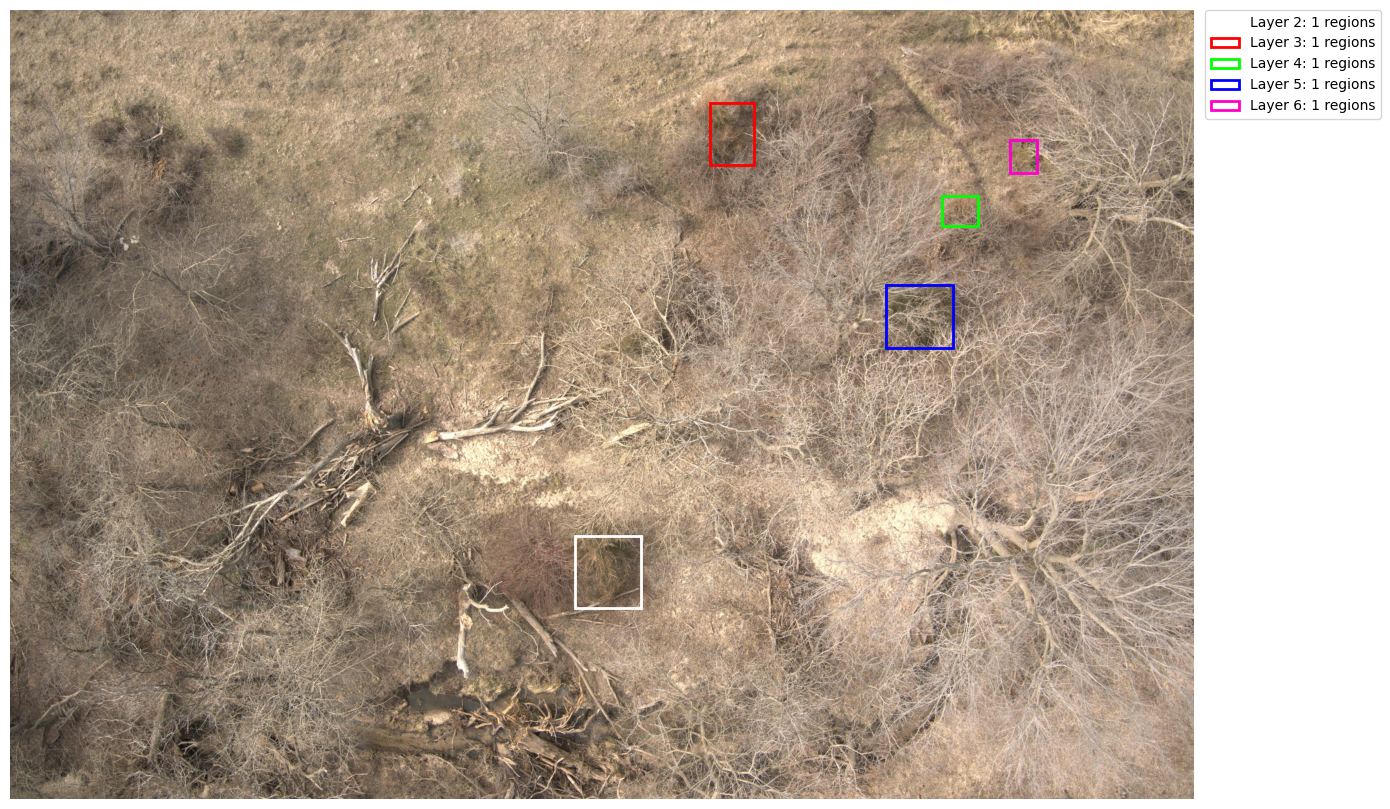

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Bounding box data exported to bounding_boxes.csv


In [7]:
# Import necessary libraries if not already imported
import cv2
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from google.colab import files
import pandas as pd

# Upload mask and original images
print("🔼 Please upload your mask image:")
uploaded_mask = files.upload()
mask_filename = list(uploaded_mask.keys())[0]

print("\n🔼 Please upload your original image:")
uploaded_original = files.upload()
original_filename = list(uploaded_original.keys())[0]

# Load images
mask_image = cv2.imread(mask_filename)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Define the color map
color_map = {
    "Layer 1 (Background)": "#000000",
    "Layer 2": "#ffffff",
    "Layer 3": "#ff0000",
    "Layer 4": "#00ff00",
    "Layer 5": "#0000ff",
    "Layer 6": "#ff00cc",
    "Layer 7": "#ff6600",
    "Layer 8": "#ffcc00",
    "Layer 9": "#00ffcc",
    "Layer 10": "#0088ff",
    "Layer 11": "#ddffdc",
}

# Define colors to exclude from processing (background and potentially noisy colors)
excluded_colors = ["#000000"]  # Exclude black background

# Convert color map to RGB for comparison
color_map_rgb = {}
for name, hex_code in color_map.items():
    if hex_code not in excluded_colors:  # Skip excluded colors
        color_map_rgb[hex_code] = tuple(int(hex_code[i:i+2], 16) for i in (1, 3, 5))

# Extract unique colors from the mask image
unique_colors = np.unique(mask_image.reshape(-1, 3), axis=0)
extracted_colors = {f"#{r:02x}{g:02x}{b:02x}": (r, g, b) for r, g, b in unique_colors}

# Function to find the closest matching color from the predefined color map
def find_closest_color(target_rgb, reference_colors):
    # Handle the case with only one reference color
    reference_rgb_values = list(reference_colors.values())

    if len(reference_rgb_values) == 1:
        return reference_rgb_values[0]

    # For multiple reference colors, use KDTree
    reference_rgb_array = np.array(reference_rgb_values)

    # Ensure target_rgb is properly shaped
    target_rgb_array = np.array(target_rgb).reshape(1, -1)

    kd_tree = KDTree(reference_rgb_array)
    _, index = kd_tree.query(target_rgb_array)
    return reference_rgb_values[index[0]]

# Alternative color matching function using Euclidean distance for robustness
def find_closest_color_euclidean(target_rgb, reference_colors):
    min_distance = float('inf')
    closest_color = None

    for hex_code, rgb in reference_colors.items():
        # Calculate Euclidean distance between colors
        distance = np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(target_rgb, rgb)))

        if distance < min_distance:
            min_distance = distance
            closest_color = rgb

    return closest_color

# Map extracted colors to the closest predefined colors
# Using the more robust Euclidean method instead of KDTree
corrected_colors = {}
for hex_color, rgb in extracted_colors.items():
    if hex_color not in excluded_colors:  # Skip excluded colors
        corrected_colors[hex_color] = find_closest_color_euclidean(rgb, color_map_rgb)

# Convert corrected colors back to hex format
corrected_colors_hex = {orig: f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}" for orig, rgb in corrected_colors.items()}

# Function to extract bounding boxes from a color mask using corrected colors (in min/max format)
def extract_bounding_boxes(mask_image, corrected_colors, min_area=100):
    color_bboxes = {}

    # Create mapping from RGB tuples to hex codes
    color_index_map = {}
    for orig_hex, corrected_hex in corrected_colors.items():
        rgb_tuple = tuple(int(corrected_hex[i:i+2], 16) for i in (1, 3, 5))
        color_index_map[rgb_tuple] = corrected_hex

    # Process each corrected color
    for target_rgb, corrected_hex in color_index_map.items():
        # Create binary mask for this color
        binary_mask = np.zeros(mask_image.shape[:2], dtype=np.uint8)

        # Find pixels that match this color
        color_match = np.all(mask_image == target_rgb, axis=2)
        binary_mask[color_match] = 255

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize the color in the bounding boxes dictionary
        if corrected_hex not in color_bboxes:
            color_bboxes[corrected_hex] = []

        # Process each contour
        for contour in contours:
            area = cv2.contourArea(contour)
            if area >= min_area:  # Only include contours above the minimum area threshold
                x, y, w, h = cv2.boundingRect(contour)
                # Convert to min/max format
                xmin, ymin = x, y
                xmax, ymax = x + w, y + h
                color_bboxes[corrected_hex].append((xmin, ymin, xmax, ymax))

    # Remove colors with no detected regions
    color_bboxes = {color: boxes for color, boxes in color_bboxes.items() if boxes}

    return color_bboxes

# Extract bounding boxes using the optimized method with minimum area threshold
min_area_threshold = 500  # Adjust this value based on your needs
color_bboxes = extract_bounding_boxes(mask_image, corrected_colors_hex, min_area=min_area_threshold)

# Function to output bounding box coordinates in the requested format
def print_bounding_box_coordinates(color_bboxes):
    # Define color_to_layer mapping
    color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

    # Create a DataFrame to store all bounding box coordinates
    all_boxes = []

    for color_hex, bboxes in color_bboxes.items():
        layer_name = color_to_layer.get(color_hex, f"Unknown ({color_hex})")
        for i, (xmin, ymin, xmax, ymax) in enumerate(bboxes):
            all_boxes.append({
                'Layer': layer_name,
                'Box #': i+1,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'Width': xmax - xmin,
                'Height': ymax - ymin,
                'Area': (xmax - xmin) * (ymax - ymin)
            })

    # Convert to DataFrame and sort by layer
    df = pd.DataFrame(all_boxes)
    if not df.empty:
        df = df.sort_values(by=['Layer', 'Area'], ascending=[True, False])

        # Print results in the requested format
        print("\n===== BOUNDING BOX COORDINATES =====")
        for _, row in df.iterrows():
            print(f"{row['Layer']} ({color_map[row['Layer']]}): xmin: {row['xmin']}, ymin: {row['ymin']}, xmax: {row['xmax']}, ymax: {row['ymax']}")

        # Return the DataFrame for further processing if needed
        return df
    else:
        print("No bounding boxes found matching the criteria")
        return None

# Function to get a dictionary of detected layers
def get_detected_layers(color_bboxes):
    # Define color_to_layer mapping
    color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

    # Create a mapping from layer name to count of detected boxes
    layer_to_boxes = {}
    for color_hex, bboxes in color_bboxes.items():
        layer_name = color_to_layer.get(color_hex, f"Unknown ({color_hex})")
        layer_to_boxes[layer_name] = len(bboxes)

    return layer_to_boxes

# Function to draw bounding boxes on the original image and save output
def draw_bounding_boxes(original_image_path, color_bboxes, output_path="output_filtered.png"):
    original = cv2.imread(original_image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Get detected layers
    detected_layers = get_detected_layers(color_bboxes)

    # Create figure with additional space for legend on the right
    fig, ax = plt.subplots(figsize=(14, 10))

    # Show the image
    ax.imshow(original)

    # Define color_to_layer mapping
    color_to_layer = {hex_code: name for name, hex_code in color_map.items()}

    # Create legend patches only for detected layers
    legend_patches = []

    # Sort detected layers by layer number
    ordered_layers = sorted(
        detected_layers.keys(),
        key=lambda x: int(x.split()[1].split('(')[0])
    )

    # Create legend entries only for detected layers
    for layer_name in ordered_layers:
        hex_code = color_map[layer_name]
        count = detected_layers[layer_name]
        legend_patches.append(Rectangle((0, 0), 1, 1, linewidth=2, edgecolor=hex_code,
                                      facecolor='none', label=f"{layer_name}: {count} regions"))

    # Draw bounding boxes
    for color_hex, bboxes in color_bboxes.items():
        for (xmin, ymin, xmax, ymax) in bboxes:
            # Convert min/max to x, y, width, height for Rectangle
            width = xmax - xmin
            height = ymax - ymin
            rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor=color_hex, facecolor='none')
            ax.add_patch(rect)

    # Add legend outside the plot area
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.01, 1),
             borderaxespad=0, fontsize=10)

    # Turn off axis
    ax.axis('off')

    # Adjust layout to make room for legend
    plt.tight_layout()

    # Save the output image with the legend
    plt.savefig(output_path, bbox_inches="tight", dpi=300)

    # Download the image in Colab
    files.download(output_path)

    plt.show()

# Print bounding box coordinates in the requested format
bbox_df = print_bounding_box_coordinates(color_bboxes)

# Print summary of detected regions
print("\nSummary of detected regions:")

# Get detected layers
detected_layers = get_detected_layers(color_bboxes)

# Sort detected layers by layer number and print summary
ordered_layers = sorted(
    detected_layers.keys(),
    key=lambda x: int(x.split()[1].split('(')[0])
)

for layer_name in ordered_layers:
    count = detected_layers[layer_name]
    print(f"{layer_name}: {count} regions detected")

# Draw bounding boxes and save output
draw_bounding_boxes(original_filename, color_bboxes)

'''
# Export bounding boxes to CSV (optional)
if bbox_df is not None:
    csv_filename = "bounding_boxes.csv"
    bbox_df.to_csv(csv_filename, index=False)
    files.download(csv_filename)
    print(f"\nBounding box data exported to {csv_filename}")
    '''

The image set represents a data generation pipeline for training computer vision models (specifically CNNs and Transformers) to perform object detection and segmentation tasks on aerial imagery.